In [1]:
# !wget https://gist.githubusercontent.com/huseinzol05/98974ae8c6c7a65d4bc0af9f5003786a/raw/5aa5257608b61e8fcc828e99fbd070d5ca7358e3/mp.py

In [2]:
# !wget https://huggingface.co/datasets/huseinzol05/Malay-TTS-Osman/resolve/main/tts-malay-osman.tar.gz
# !wget https://huggingface.co/datasets/huseinzol05/Malay-TTS-Yasmin/resolve/main/normalized-texts.json
# !tar -xf tts-malay-osman.tar.gz
# !rm tts-malay-osman.tar.gz

In [3]:
# !wget https://huggingface.co/datasets/huseinzol05/Malay-TTS-Osman/resolve/main/tts-malay-osman-parliament.tar.gz
# !wget https://huggingface.co/datasets/huseinzol05/Malay-TTS-Yasmin/resolve/main/normalized-parliaments.json
# !tar -xf tts-malay-osman-parliament.tar.gz
# !rm tts-malay-osman-parliament.tar.gz

In [4]:
# !pip3 install praat-parselmouth librosa pyworld

In [5]:
import parselmouth
import librosa
import pyworld as pw
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [6]:
import yaml

with open('config.yaml') as fopen:
    config = yaml.safe_load(fopen)
    
config

{'sampling_rate': 22050,
 'fft_size': 1024,
 'hop_size': 256,
 'win_length': None,
 'window': 'hann',
 'num_mels': 80,
 'fmin': 80,
 'fmax': 7600,
 'global_gain_scale': 1.0,
 'trim_silence': True,
 'trim_threshold_in_db': 60,
 'trim_frame_size': 2048,
 'trim_hop_size': 512}

In [7]:
import numpy as np

# https://github.com/TensorSpeech/TensorFlowTTS/blob/master/tensorflow_tts/utils/outliers.py
def is_outlier(x, p25, p75):
    """Check if value is an outlier."""
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return x <= lower or x >= upper


def remove_outlier(x, p_bottom: int = 25, p_top: int = 75):
    """Remove outlier from x."""
    p_bottom = np.percentile(x, p_bottom)
    p_top = np.percentile(x, p_top)

    indices_of_outliers = []
    for ind, value in enumerate(x):
        if is_outlier(value, p_bottom, p_top):
            indices_of_outliers.append(ind)

    x[indices_of_outliers] = 0.0
    x[indices_of_outliers] = np.max(x)
    return x

In [8]:
import re

_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)

In [9]:
import json

with open('normalized-texts.json') as fopen:
    texts = json.load(fopen)
    
with open('normalized-parliaments.json') as fopen:
    parliament = json.load(fopen)

In [10]:
def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

In [11]:
texts[0]

{'index': 0,
 'text': "Sedangkan dalam bahasa Perancis , '' frire '' hanya bererti menggoreng di dalam minyak goreng yang banyak hingga terendam .",
 'normalized': 'Sedangkan dalam bahasa Perancis , frire hanya bererti menggoreng di dalam minyak goreng yang banyak hingga terendam .'}

In [12]:
tts_encode(texts[0]['normalized'])

[32,
 44,
 43,
 40,
 53,
 46,
 50,
 40,
 53,
 13,
 43,
 40,
 51,
 40,
 52,
 13,
 41,
 40,
 47,
 40,
 58,
 40,
 13,
 29,
 44,
 57,
 40,
 53,
 42,
 48,
 58,
 13,
 8,
 13,
 45,
 57,
 48,
 57,
 44,
 13,
 47,
 40,
 53,
 64,
 40,
 13,
 41,
 44,
 57,
 44,
 57,
 59,
 48,
 13,
 52,
 44,
 53,
 46,
 46,
 54,
 57,
 44,
 53,
 46,
 13,
 43,
 48,
 13,
 43,
 40,
 51,
 40,
 52,
 13,
 52,
 48,
 53,
 64,
 40,
 50,
 13,
 46,
 54,
 57,
 44,
 53,
 46,
 13,
 64,
 40,
 53,
 46,
 13,
 41,
 40,
 53,
 64,
 40,
 50,
 13,
 47,
 48,
 53,
 46,
 46,
 40,
 13,
 59,
 44,
 57,
 44,
 53,
 43,
 40,
 52,
 13,
 9,
 2]

In [13]:
!rm -rf output-osman

In [14]:
directory = 'output-osman'
os.system(f'mkdir {directory}')
directories = ['audios', 'mels', 'text_ids', 'f0s', 'energies', 'pitches']
for d in directories:
    os.system(f'mkdir {directory}/{d}')

In [15]:
txts = [(f"male/{t['index']}.wav", t['normalized'], t['index'], directory) for t in texts]

In [16]:
txts[0]

('male/0.wav',
 'Sedangkan dalam bahasa Perancis , frire hanya bererti menggoreng di dalam minyak goreng yang banyak hingga terendam .',
 0,
 'output-osman')

In [17]:
import malaya_speech
from malaya_speech import Pipeline
from tqdm import tqdm
vad = malaya_speech.vad.webrtc()

def process(txts, 
            start_silent_trail = int(0.05 * config['sampling_rate']),
            middle_silent_trail = int(0.12 * config['sampling_rate']),
            end_silent_trail = int(0.1 * config['sampling_rate']),
            process_middle_silent = True,
            maxlen = 25):
    
    txts = txts[0]
    audios, mels, text_ids, f0s, energies, pitches = [], [], [], [], [], []

    for f in txts:
        directory = f[3]
        index = f[2]
        text = f[1]
        f = f[0]
            
        text = [text, tts_encode(text)]
        audio, _ = malaya_speech.load(f, sr = config['sampling_rate'])
        audio = audio[start_silent_trail:]

        if config['trim_silence']:
            y_= malaya_speech.resample(audio, config['sampling_rate'], 16000)
            y_ = malaya_speech.astype.float_to_int(y_)
            frames = list(malaya_speech.generator.frames(audio, 30, config['sampling_rate']))
            frames_ = list(malaya_speech.generator.frames(y_, 30, 16000, append_ending_trail = False))
            frames_webrtc = [(frames[no], vad(frame)) for no, frame in enumerate(frames_)]
            grouped_deep = malaya_speech.group.group_frames(frames_webrtc)
            grouped_deep = malaya_speech.group.group_frames_threshold(grouped_deep, 0.15)
            r = []
            for no, g in enumerate(grouped_deep):
                if g[1]:
                    g = g[0].array
                else:
                    if no == 0:
                        g = g[0].array[-start_silent_trail:]
                    elif no == (len(grouped_deep) - 1):
                        g = g[0].array[:end_silent_trail]
                    else:
                        if process_middle_silent:
                            g = np.concatenate([g[0].array[:middle_silent_trail], g[0].array[-middle_silent_trail:]])
                        else:
                            g = g[0].array
                        
                r.append(g)
            audio = np.concatenate(r)
        
        if (len(audio) / config['sampling_rate']) > maxlen:
            print('skipped, audio too long')
            continue

        D = librosa.stft(
            audio,
            n_fft=config['fft_size'],
            hop_length=config['hop_size'],
            win_length=config['win_length'],
            window=config['window'],
            pad_mode='reflect',
        )
        S, _ = librosa.magphase(D) 
        fmin = 0 if config["fmin"] is None else config["fmin"]
        fmax = sampling_rate // 2 if config["fmax"] is None else config["fmax"]
        mel_basis = librosa.filters.mel(
            sr=config['sampling_rate'],
            n_fft=config["fft_size"],
            n_mels=config["num_mels"],
            fmin=fmin,
            fmax=fmax,
        )
        mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
        audio = np.pad(audio, (0, config["fft_size"]), mode="edge")
        audio = audio[: len(mel) * config['hop_size']]

        _f0, t = pw.dio(
            audio.astype(np.double),
            fs=config['sampling_rate'],
            f0_ceil=fmax,
            frame_period=1000 * config['hop_size'] / config['sampling_rate'],
        )
        f0 = pw.stonemask(audio.astype(np.double), _f0, t, config['sampling_rate'])
        if len(f0) >= len(mel):
            f0 = f0[: len(mel)]
        else:
            f0 = np.pad(f0, (0, len(mel) - len(f0)))

        # extract energy
        energy = np.sqrt(np.sum(S ** 2, axis=0))
        f0 = remove_outlier(f0)
        energy = remove_outlier(energy)
        
        mel_len = len(mel)
        snd = parselmouth.Sound(audio,sampling_frequency=22050)
        pitch = snd.to_pitch(time_step=snd.duration / (mel_len + 3)
                         ).selected_array['frequency']

        if config["global_gain_scale"] > 0.0:
            audio *= config["global_gain_scale"]

        if len(energy[energy != 0]) == 0 or len(f0[f0 != 0]) == 0:
            print('skipped')
            continue
            
        np.save(f'{directory}/audios/{index}.npy', audio)
        np.save(f'{directory}/mels/{index}.npy', mel)
        np.save(f'{directory}/text_ids/{index}.npy', text)
        np.save(f'{directory}/f0s/{index}.npy', f0)
        np.save(f'{directory}/energies/{index}.npy', energy)

        audios.append(audio)
        mels.append(mel)
        text_ids.append(text)
        f0s.append(f0)
        energies.append(energy)
        pitches.append(pitch)
    
    return [[audios, mels, text_ids, f0s, energies, pitches]]

/home/ubuntu/.local/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/tensorflow_addons/utils/resource_loader.py:72: UserWarning: You are currently using TensorFlow 2.6.0 and trying to load a custom op (custom_ops/seq2seq/_beam_search_ops.so).
TensorFlow Addons has compiled its custom ops again

In [18]:
import matplotlib.pyplot as plt
import IPython.display as ipd

In [20]:
%%time

i = 1508
r = process((txts[i: i + 10], 0))[0]

CPU times: user 4.38 s, sys: 11.3 s, total: 15.6 s
Wall time: 1.46 s


In [21]:
for n in range(len(r[2])):
    print(n, r[2][n][0])

0 Campur tangan Rom di Armenia ( tiga empat tiga tujuh ) .
1 Walauun Kyle berkelakuan seperti bayi , di belajar dengan kelajuan yang menakjubkan dan menggunakan segala ilmu yang dikecapinya .
2 Masjid Sungai Siput memiliki nombor pendaftaran masjid No Daftar : MY dash empat - AG dash lapan puluh dua .
3 asterisk Tujuh pengganti yang dinamakan , yang mana sehingga tiga boleh digunakan .
4 Anugerah Buku Negara dua ribu dua belas .
5 Kepungan itu berakhir selepas Yazid meninggal dunia secara mengejut pada tahun enam ratus lapan puluh tiga .
6 Penyebabnya tidak diketahui dalam sembilan puluh peratus hingga sembilan puluh lima peratus kes .
7 Dan in Real Life merupakan satu filem drama komedi dua ribu tujuh Amerika .
8 Pengajaran dan pembelajaran dijalankan di dalam kontainer , tadika dan bilik komputer .
9 Teras kuasa Dojo mereka selamat dari dimusnahkan oleh Kali .


In [22]:
k = 6
ipd.Audio(r[0][k], rate = 22050)

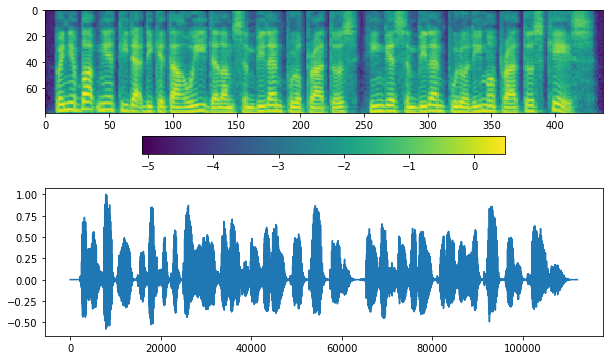

In [23]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(10)
fig.set_figheight(nrows * 3)
mel_outputs_ = np.reshape(r[1][k], [-1, 80])
im = ax[0].imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax[0])
ax[1].plot(r[0][k])
plt.show()

In [24]:
import mp

for i in tqdm(range(0, len(txts), 1000)):
    index = min(i + 1000, len(txts))
    b = txts[i: index]
    mp.multiprocessing(b, process, cores = 3, returned = False)

  0%|          | 0/50 [00:00<?, ?it/s]/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (whi

/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
 14%|█▍        | 7/50 [12:50<1:19:00, 110.25s/it]/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested seq

skipped, audio too long


 26%|██▌       | 13/50 [24:05<1:09:04, 112.02s/it]/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested se

/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
 40%|████      | 20/50 [37:00<55:03, 110.10s/it]/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequ

/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
 54%|█████▍    | 27/50 [49:44<42:02, 109.66s/it]/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequ

 66%|██████▌   | 33/50 [1:00:55<31:29, 111.15s/it]/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested se

/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
 80%|████████  | 40/50 [1:13:30<17:58, 107.84s/it]/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested se

/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
 94%|█████████▍| 47/50 [1:26:12<05:27, 109.10s/it]/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested se

In [25]:
!du -hs output-osman

66G	output-osman


In [26]:
directory = 'output-osman-parliament'
os.system(f'mkdir {directory}')
directories = ['audios', 'mels', 'text_ids', 'f0s', 'energies', 'pitches']
for d in directories:
    os.system(f'mkdir {directory}/{d}')

In [27]:
txts = [(f"male-parliament/{t['index']}.wav", t['normalized'], t['index'], directory) for t in parliament]

In [28]:
i = 80
r = process((txts[i: i + 10], 0))[0]

/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [29]:
for n in range(len(r[2])):
    print(n, r[2][n][0])

0 Pada tahun dua ribu sebelas purata sembilan puluh lima ribu lapan ratus sembilan puluh sembilan penumpang telah menggunakan penumpang setiap hari pada tahun dua ribu tiga belas .
1 Ancaman kumpulan militan IS terhadap Malaysia dan juga dunia adalah membimbangkan kerana ianya melibatkan ideologi yang berlandaskan prinsip - prinsip keagamaan .
2 Undang Syarak dan Sivil pada tahun sembilan belas lapan puluh lapan yang diurus setiakan oleh Jabatan Kemajuan Islam Malaysia ( JAKIM ) .
3 Begitu juga dengan rundingan mengenai ISDS , pasukan rundingan masih berunding secara teliti terhadap skop ISDS .
4 bagi mengimbangi kesan penarikan diri Amerika Syarikat .
5 Mana - mana pihak yang melanggar Subseksyen dua belas ( satu ) adalah melakukan suatu kesalahan dan boleh didenda antara dua ratus lima puluh ribu RM hingga lima ratus ribu RM apabila disa kesalahan .
6 fiskal jangka panjang negara .
7 Jawatankuasa ini bertanggungjawab untuk menimbang teliti dan memutuskan syor yang dibuat oleh Majlis 

In [30]:
k = 0
ipd.Audio(r[0][k], rate = 22050)

In [ ]:
for i in tqdm(range(0, len(txts), 1000)):
    index = min(i + 1000, len(txts))
    b = txts[i: index]
    mp.multiprocessing(b, process, cores = 3, returned = False)

  3%|▎         | 2/60 [04:00<1:56:01, 120.03s/it]

skipped, audio too long
skipped, audio too long


  7%|▋         | 4/60 [08:04<1:53:42, 121.83s/it]

skipped, audio too long


  8%|▊         | 5/60 [10:04<1:50:58, 121.06s/it]

skipped, audio too long


 12%|█▏        | 7/60 [14:13<1:48:32, 122.88s/it]

skipped, audio too long


 15%|█▌        | 9/60 [18:15<1:43:31, 121.80s/it]

skipped, audio too long
skipped, audio too long


 22%|██▏       | 13/60 [26:22<1:35:22, 121.75s/it]

skipped, audio too long


 27%|██▋       | 16/60 [32:24<1:28:59, 121.35s/it]

skipped, audio too long


 30%|███       | 18/60 [36:24<1:24:31, 120.75s/it]

skipped, audio too long


 35%|███▌      | 21/60 [42:27<1:18:46, 121.19s/it]

skipped, audio too long


 37%|███▋      | 22/60 [44:27<1:16:34, 120.90s/it]

skipped, audio too long


 40%|████      | 24/60 [48:28<1:12:22, 120.62s/it]

skipped, audio too long


 42%|████▏     | 25/60 [50:27<1:10:03, 120.09s/it]

skipped, audio too long


 48%|████▊     | 29/60 [58:31<1:02:22, 120.71s/it]

skipped, audio too long


 50%|█████     | 30/60 [1:00:31<1:00:12, 120.40s/it]

skipped, audio too long


 55%|█████▌    | 33/60 [1:06:37<54:40, 121.51s/it]  

skipped, audio too long


 57%|█████▋    | 34/60 [1:08:39<52:40, 121.55s/it]

skipped, audio too long


 63%|██████▎   | 38/60 [1:16:51<44:52, 122.39s/it]

skipped, audio too long


 67%|██████▋   | 40/60 [1:20:56<40:48, 122.44s/it]

skipped, audio too long


 72%|███████▏  | 43/60 [1:27:04<34:40, 122.41s/it]

skipped, audio too long
skipped, audio too long


 73%|███████▎  | 44/60 [1:29:08<32:45, 122.86s/it]

skipped, audio too long


 78%|███████▊  | 47/60 [1:35:10<26:20, 121.56s/it]

skipped, audio too long
skipped, audio too long


 80%|████████  | 48/60 [1:37:11<24:15, 121.33s/it]

In [33]:
!du -hs output-osman-parliament

95G	output-osman-parliament


In [ ]:
scaler_mel = StandardScaler(copy=False)
scaler_energy = StandardScaler(copy=False)
scaler_f0 = StandardScaler(copy=False)

In [ ]:
from glob import glob

mels = glob('output-osman/mels/*.npy')
len(mels)

In [ ]:
for f in tqdm(mels):
    mel = np.load(f)
    f0 = np.load(f.replace('mels/', 'f0s/'))
    energy = np.load(f.replace('mels/', 'energies/'))
    
    scaler_mel.partial_fit(mel)
    scaler_energy.partial_fit(energy[energy != 0].reshape(-1, 1))
    scaler_f0.partial_fit(f0[f0 != 0].reshape(-1, 1))

In [ ]:
mels = glob('output-osman-parliament/mels/*.npy')
len(mels)

In [ ]:
for f in tqdm(mels):
    mel = np.load(f)
    f0 = np.load(f.replace('mels/', 'f0s/'))
    energy = np.load(f.replace('mels/', 'energies/'))
    
    scaler_mel.partial_fit(mel)
    scaler_energy.partial_fit(energy[energy != 0].reshape(-1, 1))
    scaler_f0.partial_fit(f0[f0 != 0].reshape(-1, 1))

In [ ]:
directory_stats = 'osman-stats'

In [ ]:
def save_statistics_to_file(scaler_list, config):
    os.system(f'mkdir {directory_stats}')
    for scaler, name in scaler_list:
        stats = np.stack((scaler.mean_, scaler.scale_))
        np.save(
            os.path.join(f"{directory_stats}/stats{name}.npy"),
            stats.astype(np.float32),
            allow_pickle=False,
        )

In [ ]:
scaler_list = [(scaler_mel, ""), (scaler_energy, "_energy"), (scaler_f0, "_f0")]
save_statistics_to_file(scaler_list, config)